In [1]:
import torch
from pathlib import Path

import eq

## Loading the catalog
We load the catalog like in the previous notebook.

In [2]:
catalog = eq.catalogs.White()

Loading existing catalog from /nfs/homedirs/shchur/research/earthquake-ntpp-release/data/White.


## Loading a trained model
All models trained on the default versions of the catalog are stored in `{PROJECT_ROOT_DIR}/trained_models/`.

In [3]:
trained_models_dir = Path(eq.__file__).parents[1] / "trained_models"
trained_models_dir

PosixPath('/nfs/homedirs/shchur/research/earthquake-ntpp-release/trained_models')

In [4]:
model = eq.models.RecurrentTPP.load_from_checkpoint(trained_models_dir / "White_RecurrentTPP.ckpt")
model.eval()

RecurrentTPP(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Prepare the data

We trained the TPP model using the `train` and `val` sequences. Now we will use the unseen section of the `test` sequence (in orange) to evaluate forecasting performance of the model.

<AxesSubplot:xlabel='Arrival time (days)', ylabel='Magnitude'>

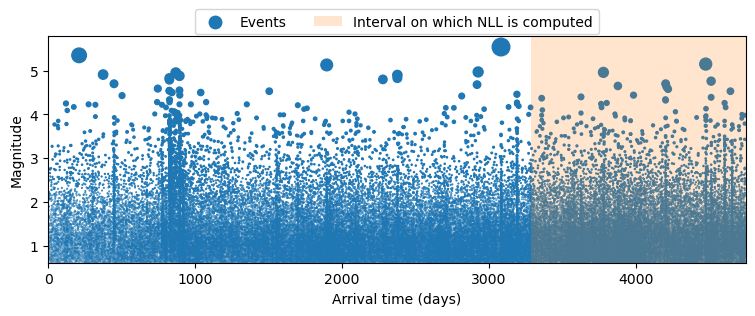

In [5]:
test_seq = catalog.test[0]
eq.visualization.visualize_sequence(test_seq, show_nll=True)

We would like to generate a 7-day forecast for the interval `[4000, 4007]`. For this, we select two subsequences:
- `past_seq`: Contains events from `[0, 4000]`, is used to condition the model
- `observed_seq`: Contains actually observed events from `[4000, 4007]`.

In [6]:
t_forecast = 4000
duration = 7
num_samples = 10_000

# Past events that we condition on
past_seq = test_seq.get_subsequence(0, t_forecast)
# Observed events in the 7-day forecast window
observed_seq = test_seq.get_subsequence(t_forecast, t_forecast + duration)

/nfs/homedirs/shchur/research/earthquake-ntpp-release/eq/data/sequence.py:153: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


## Generate the forecast

In [7]:
# Use GPU to speed up forecasting, if possible
if torch.cuda.is_available():
    model.cuda()
    past_seq.cuda()

In [8]:
forecast = model.sample(batch_size=num_samples, duration=duration, past_seq=past_seq, return_sequences=True)

`forecast` is a list, where each element is a `eq.data.Sequence` that represents a possible continuation of the catalog over the interval `[4000, 4007]`.

With the following function, we
- visualize 10 randomly chosen trajectories as a counting process
- plot the distribution of the total # of events in the forecast interval

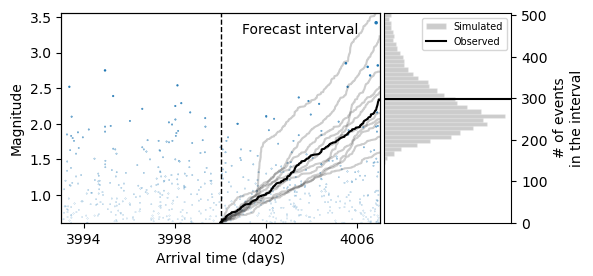

In [9]:
eq.visualization.visualize_trajectories(test_seq, forecast)